In [16]:
import numpy as np
from hmmlearn import hmm
import warnings
from sklearn import neighbors, preprocessing
import pandas as pd
import seaborn as sns
import pprint


from analytic import utility, ta_indicators, statistics, visual

import math
from matplotlib import cm
from matplotlib import pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from scipy import stats

# please run $ jupyter notebook at "udacity/_p_f/src" folder

In [17]:
symbols = ('AMAT', )
csv_files = [utility.get_appropriate_file(symbol) for symbol in symbols]
requested_col = ['time', 'high', 'low', 'open', 'close']
the_df = utility.get_cols_from_csv_names(file_names=csv_files,
                                         interested_col=requested_col,
                                         join_spy_for_data_integrity=False,
                                         keep_spy_if_not_having_spy=False,
                                         base_dir="./rawdata")
daily_grp = the_df.groupby(pd.Grouper(level=0, freq='1d'))
daily_rtn = (daily_grp['AMAT_CLOSE'].last() - daily_grp['AMAT_OPEN'].first()) / daily_grp['AMAT_OPEN'].first()
daily_rtn = daily_rtn.dropna()
daily_rtn.name = "AMAT_RTN"

rocp = ta_indicators.get_rocp(the_df['AMAT_CLOSE'], '60s', None, expanding=True)

# get rolling t-test
rocp_mean = rocp.mean()
rocp_std = rocp.std()
rocp_nobs = len(rocp)
kwargs = {
    "mean2": rocp_mean,
    "std2": rocp_std,
    "nobs2": rocp_nobs
}
print("rocp_mean: {0:.9f}, rocp_std: {1:.9f}, rocp_nobs: {2:d}".format(
    rocp_mean, rocp_std, rocp_nobs))




rocp_mean: -0.000002602, rocp_std: 0.000831548, rocp_nobs: 58140


time
2017-11-17 09:30:00    0.000000
2017-11-17 09:31:00   -4.374454
2017-11-17 09:32:00   -9.345424
2017-11-17 09:33:00   -9.345424
2017-11-17 09:34:00   -9.345424
2017-11-17 09:35:00   -5.249345
2017-11-17 09:36:00   -4.407594
2017-11-17 09:37:00   -4.430337
2017-11-17 09:38:00   -5.019103
2017-11-17 09:39:00   -5.019103
2017-11-17 09:40:00   -2.928681
2017-11-17 09:41:00   -4.505361
2017-11-17 09:42:00   -3.806777
2017-11-17 09:43:00   -3.806777
2017-11-17 09:44:00   -4.708642
2017-11-17 09:45:00   -2.775282
2017-11-17 09:46:00   -3.277893
2017-11-17 09:47:00   -3.551051
2017-11-17 09:48:00   -3.551051
2017-11-17 09:49:00   -3.551051
2017-11-17 09:50:00   -1.809670
2017-11-17 09:51:00   -0.858003
2017-11-17 09:52:00   -0.947560
2017-11-17 09:53:00   -1.579266
2017-11-17 09:54:00   -1.304611
2017-11-17 09:55:00   -4.224992
2017-11-17 09:56:00   -4.224992
2017-11-17 09:57:00   -4.224992
2017-11-17 09:58:00   -2.431947
2017-11-17 09:59:00   -2.431947
Name: AMAT_CLOSE, dtype: float64
A 

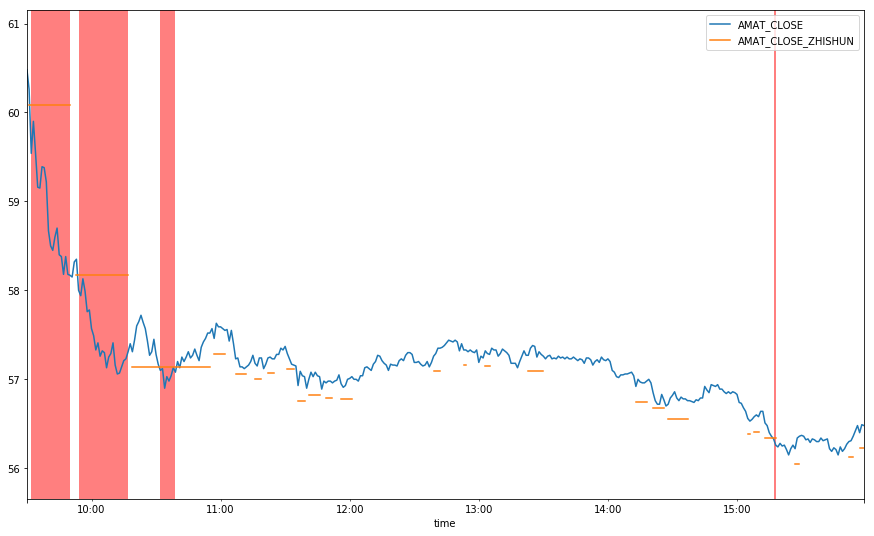

In [18]:
kwargs = {
    "mean2": rocp_mean,
    "std2": rocp_std,
    "nobs2": rocp_nobs
}
col_name_map = {
    'open': 'AMAT_OPEN',
    'high': 'AMAT_HIGH',
    'low': 'AMAT_LOW',
    'close': 'AMAT_CLOSE',
}
# 2017-11-13  -> 2017-11-20, 2017-11-17 da die

selected_date = '2017-11-17'
the_df_selected = the_df.loc[selected_date]
closes_of_selected = the_df_selected['AMAT_CLOSE']
ax = closes_of_selected.plot(figsize=(15, 9), legend=True, 
                             ylim=(closes_of_selected.min() - 0.5, 
                                   closes_of_selected.min() + 5))
drop_downs = closes_of_selected.rolling(window=7, min_periods=1)\
    .apply(statistics.drop_down, kwargs=kwargs)
print(drop_downs.head(30))
zhishun_line = ta_indicators.get_zhishun(
    closes_of_selected, drop_downs <= -1, buffer=0.003)

zhishun_line.plot(ax=ax, legend=True)
import matplotlib.transforms as mtransforms
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(closes_of_selected.index, 
                0, 1,
                where=(closes_of_selected < zhishun_line).values, 
                facecolor='red', alpha=0.5, transform=trans)
print("A slump, the purpose of this algorithm")
print("AMAT {}".format(selected_date))
plt.show()

a special case which triggered many transactions, needs to take a look
AMAT 2017-08-18


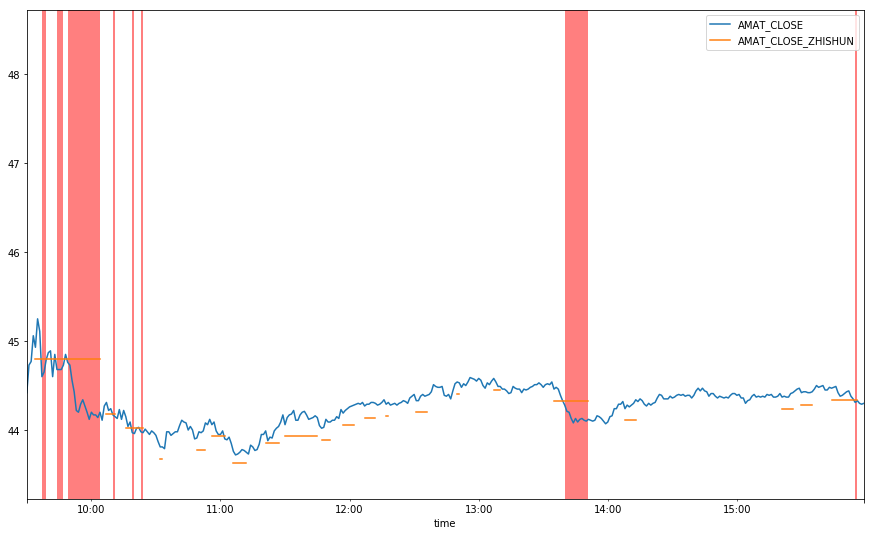

In [19]:
selected_date = '2017-08-18'
the_df_selected = the_df.loc[selected_date]
closes_of_selected = the_df_selected['AMAT_CLOSE']
ax = closes_of_selected.plot(figsize=(15, 9), legend=True, 
                             ylim=(closes_of_selected.min() - 0.5, 
                                   closes_of_selected.min() + 5))
drop_downs = closes_of_selected.rolling(window=7, min_periods=1)\
    .apply(statistics.drop_down, kwargs=kwargs)
zhishun_line = ta_indicators.get_zhishun(
    closes_of_selected, drop_downs <= -1, buffer=0.003)

zhishun_line.plot(ax=ax, legend=True)
import matplotlib.transforms as mtransforms
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(closes_of_selected.index, 
                0, 1,
                where=(closes_of_selected < zhishun_line).values, 
                facecolor='red', alpha=0.5, transform=trans)
print("a special case which triggered many transactions, needs to take a look")
print("AMAT {}".format(selected_date))
plt.show()

normal no up no down
AMAT 2017-10-04


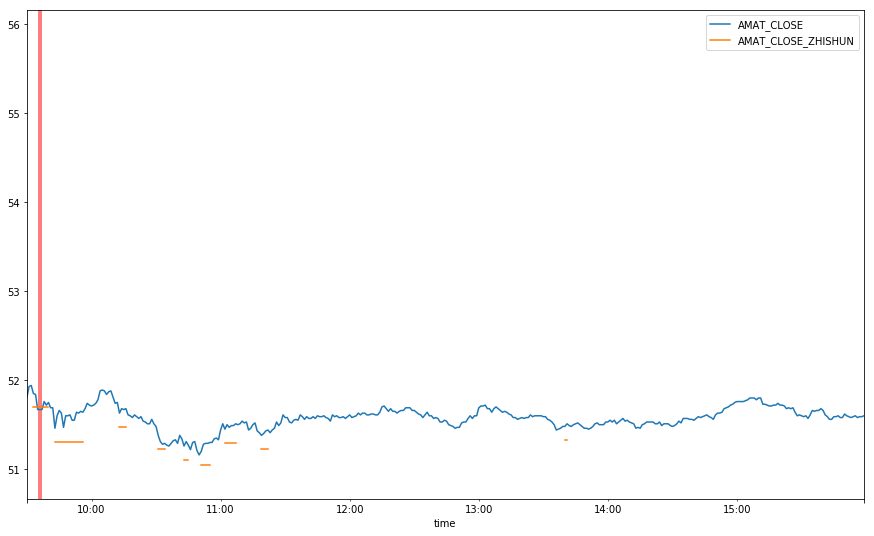

In [20]:
selected_date = '2017-10-04'
the_df_selected = the_df.loc[selected_date]
closes_of_selected = the_df_selected['AMAT_CLOSE']
ax = closes_of_selected.plot(figsize=(15, 9), legend=True, 
                             ylim=(closes_of_selected.min() - 0.5, 
                                   closes_of_selected.min() + 5))
drop_downs = closes_of_selected.rolling(window=7, min_periods=1)\
    .apply(statistics.drop_down, kwargs=kwargs)
zhishun_line = ta_indicators.get_zhishun(
    closes_of_selected, drop_downs <= -1, buffer=0.003)

zhishun_line.plot(ax=ax, legend=True)
import matplotlib.transforms as mtransforms
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(closes_of_selected.index, 
                0, 1,
                where=(closes_of_selected < zhishun_line).values, 
                facecolor='red', alpha=0.5, transform=trans)
print("normal no up no down")
print("AMAT {}".format(selected_date))
plt.show()

normal go down
AMAT 2017-12-04


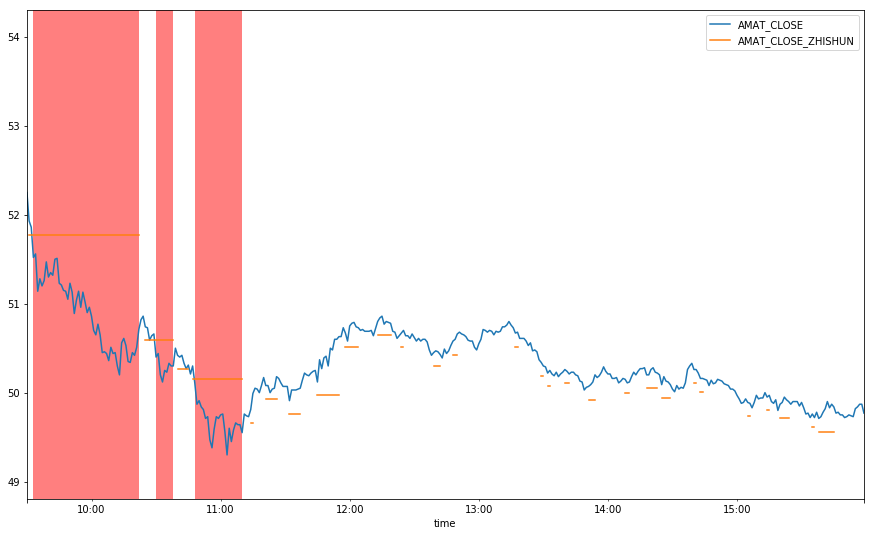

In [21]:
selected_date = '2017-12-04'
the_df_selected = the_df.loc[selected_date]
closes_of_selected = the_df_selected['AMAT_CLOSE']
ax = closes_of_selected.plot(figsize=(15, 9), legend=True, 
                             ylim=(closes_of_selected.min() - 0.5, 
                                   closes_of_selected.min() + 5))
drop_downs = closes_of_selected.rolling(window=7, min_periods=1)\
    .apply(statistics.drop_down, kwargs=kwargs)
zhishun_line = ta_indicators.get_zhishun(
    closes_of_selected, drop_downs <= -1, buffer=0.003)

zhishun_line.plot(ax=ax, legend=True)
import matplotlib.transforms as mtransforms
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(closes_of_selected.index, 
                0, 1,
                where=(closes_of_selected < zhishun_line).values, 
                facecolor='red', alpha=0.5, transform=trans)
print("normal go down")
print("AMAT {}".format(selected_date))
plt.show()

normal go up
AMAT 2017-10-06


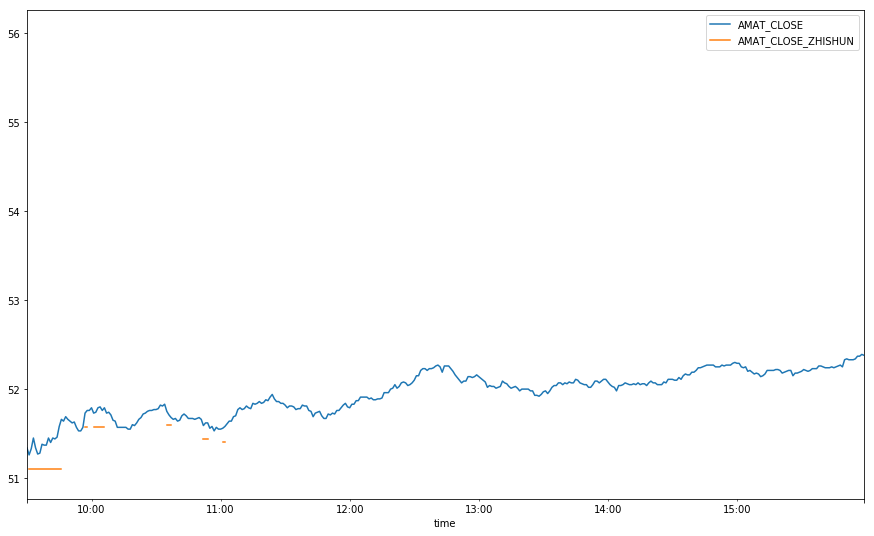

In [22]:
selected_date = '2017-10-06'
the_df_selected = the_df.loc[selected_date]
closes_of_selected = the_df_selected['AMAT_CLOSE']
ax = closes_of_selected.plot(figsize=(15, 9), legend=True, 
                             ylim=(closes_of_selected.min() - 0.5, 
                                   closes_of_selected.min() + 5))
drop_downs = closes_of_selected.rolling(window=7, min_periods=1)\
    .apply(statistics.drop_down, kwargs=kwargs)
zhishun_line = ta_indicators.get_zhishun(
    closes_of_selected, drop_downs <= -1, buffer=0.003)

zhishun_line.plot(ax=ax, legend=True)
import matplotlib.transforms as mtransforms
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(closes_of_selected.index, 
                0, 1,
                where=(closes_of_selected < zhishun_line).values, 
                facecolor='red', alpha=0.5, transform=trans)
print("normal go up")
print("AMAT {}".format(selected_date))
plt.show()